# Lung Classification Tutorial

#### In this course you will learn how to run a deep learning experiment - from loading data, running a model, and deploying your model on a test dataset.

This course will build upon the knowledge gained in the first lesson and will utilize a much larger dataset.

In this course you will build a deep learning model that identifies whether an x-ray of the lungs contains an opacity. The dataset is from a Kaggle challenge.

The dataset comes from the RSNA Pneumonia Detection Challenge (Kaggel API)
        ,
        "The [Radiological Society of North America](http://www.rsna.org/) Pneumonia Detection Challenge: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge",


<img src="https://github.com/ImagingInformatics/machine-learning/blob/master/SiiM2019/images/lesson2_datasetImage.png?raw=1">

In this notebook some of the cells need to be entered by you to work on completing the assignment. These cells have:

```python
#--------EDIT THIS CELL------------
```

at the top of the cell.

For instance, you will see a few cells down where you need to setup the variable 'p' to store the data for this project.

```python
#--------EDIT THIS CELL------------

# Load project data into a variable 'p'
```

The 'helper_utils.ipynb' file has details that can be used if you get stuck.


In [1]:
# Include the mdai module
!pip install --upgrade --quiet mdai
import mdai
mdai.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 13.2 MB/s eta 0:00:00


'0.14.0'

In [2]:
# Add mdai client
mdai_client = mdai.Client(domain='public.md.ai', access_token="dc09a676944f65a073c054f0934f2267")

Successfully authenticated to public.md.ai.


In [7]:
#--------EDIT THIS CELL------------

# Load project data into a variable 'p'
p = mdai_client.project('LxR6zdR2', path='./lung-opacity-data')

Using path './lung-opacity-data' for data.
Preparing annotations export for project LxR6zdR2...                                                
Preparing images export for project LxR6zdR2...                                                     


18.5MB [00:00, 99.3MB/s]                            


Success: annotations data for project LxR6zdR2 ready.


3.18GB [00:44, 75.9MB/s]                            


Extracting archive: mdai_public_project_LxR6zdR2_images_2018-08-20-184248.zip
Success: images data for project LxR6zdR2 ready.


In [8]:
p.show_label_groups()

Label Group, Id: G_R28gN5, Name: Default group
	Labels:
	Id: L_ylR0L8, Name: No Lung Opacity
	Id: L_DlqEAl, Name: Lung Opacity



In [9]:
#--------EDIT THIS CELL------------

# map the label ids to class ids as a dictionary object.
# this maps label ids to class ids as a dict obj
labels_dict = {'L_ylR0L8':0, # No Lung Opacity
               'L_DlqEAl':1, # Lung Opacity
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_ylR0L8': 0, 'L_DlqEAl': 1}


In [10]:
# print label dictionary and set up

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_ylR0L8': 0, 'L_DlqEAl': 1}


In [11]:
# show dataset ID and label mappings
p.show_datasets()

Datasets:
Id: D_ao3XWQ, Name: stage 1 train



### Display label classes

In [12]:
dataset = p.get_dataset_by_id('D_ao3XWQ')
dataset.prepare()
dataset.show_classes()

Label id: L_ylR0L8, Class id: 0, Class text: No Lung Opacity
Label id: L_DlqEAl, Class id: 1, Class text: Lung Opacity


In [13]:
anns = dataset.get_annotations()

In [14]:
# Separate dataset into train, val, and test

train_dataset, val_dataset = mdai.common_utils.train_test_split(dataset, validation_split = 0.98)
val_dataset, test_dataset = mdai.common_utils.train_test_split(val_dataset, validation_split = 0.995)
test_dataset, test_dataset2 = mdai.common_utils.train_test_split(test_dataset, validation_split = 0.90)

Num of instances for training set: 513, validation set: 25171
Num of instances for training set: 125, validation set: 25046
Num of instances for training set: 2504, validation set: 22542


In [15]:
anns = dataset.get_annotations(labels_dict.keys(), verbose=True)

Dataset contains 28989 annotations, filtered by label ids dict_keys(['L_ylR0L8', 'L_DlqEAl']).


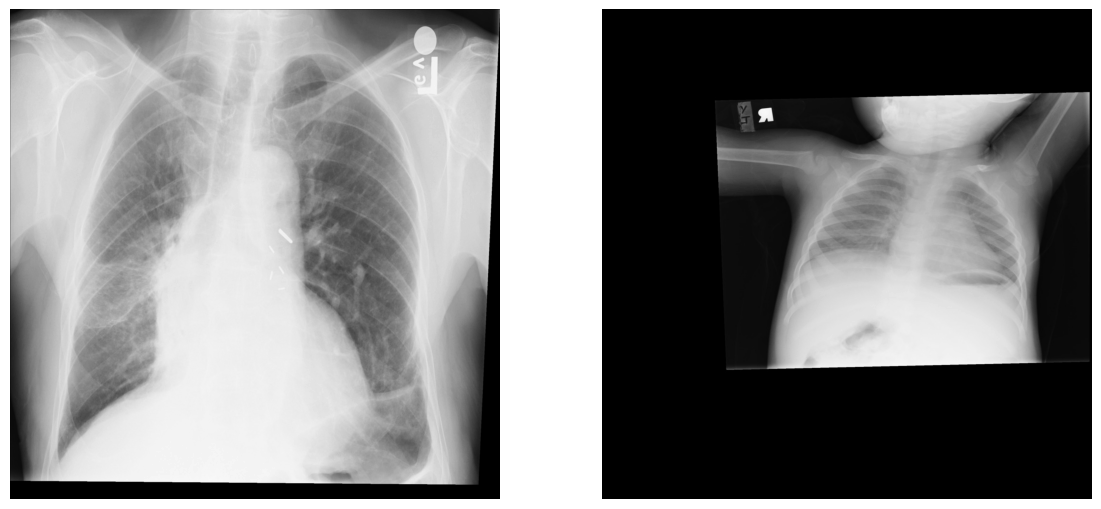

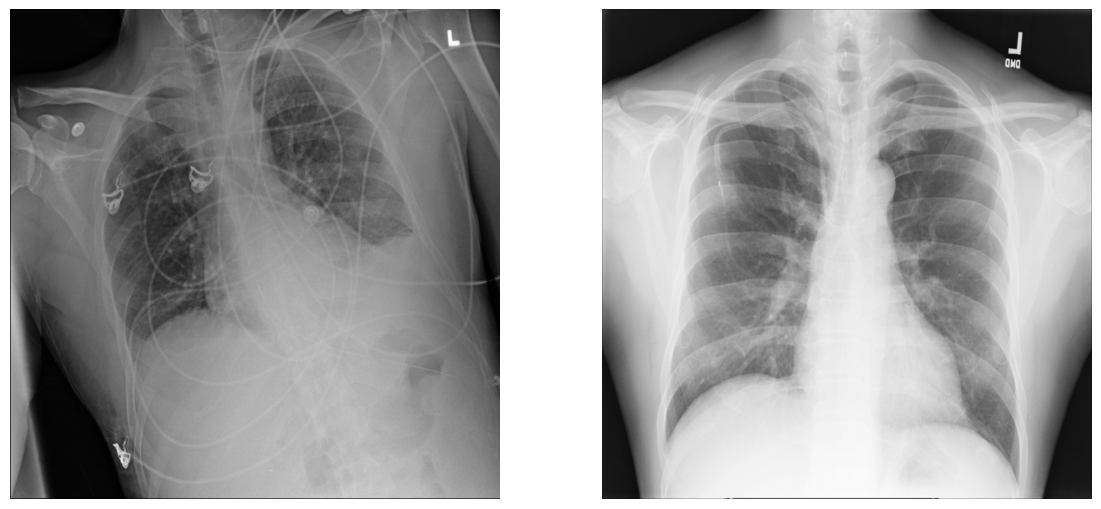

In [16]:
train_image_ids = train_dataset.get_image_ids()
val_image_ids = val_dataset.get_image_ids()

# visualize a few train images
mdai.visualize.display_images(train_image_ids[:2], cols=2)
mdai.visualize.display_images(val_image_ids[:2], cols=2)

In [17]:
#Example extracting pixel array from the dicom data
import numpy as np
# get image pixel data
pixel_array = mdai.visualize.load_dicom_image(train_image_ids[0], to_RGB=False, rescale=True)
print(np.shape(pixel_array))

(1024, 1024)


In [18]:
# Import keras module
from keras import applications
from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
# Define model parameters
img_width = 128
img_height = 128
epochs = 20

params = {
    'dim': (img_width, img_height),
    'batch_size': 8,
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': True,
}

# Begin Defining Model

Here we build up a very basic CNN architecture (similar in nature to the VGG class of architectures).

Here is where you can feel free to experiment with different architectures and tune the hyperparameters of the network. You should observe differences in training performance, as well as the amount of time required to fully train the network.

Try changing the number of kernels in the network from 32 down to 16.

For example:

```python
conv1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
```

Or changing the size of the filter kernels from 3x3 to 5x5

```python
conv1 = Conv2D(32, (5,5), activation = 'relu', padding='same')(inputs)
```

Or the activation function for the output:

```python
conv1 = Conv2D(32, (3,3), activation = 'tanh', padding='same')(inputs)
```

How do these parameters affect performance and training time?

In [24]:
#--------EDIT THIS CELL------------

# Create a CNN model to train
# This can be similar to the one used in the previous notebook
# (i.e. chest vs. abdomen X-ray)
inputs = Input((img_width, img_height, 3))

# Block1
conv1 = Conv2D(32, (3,3), activation = 'relu', padding='same')(inputs)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(conv1)
max1 = MaxPooling2D((4,4), strides = (4,4))(conv2)

# Block2
conv3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(max1)
conv4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv3)
max2 = MaxPooling2D((4,4), strides = (4,4))(conv4)

fcn = Flatten()(max2)
fcn = Dense(512,activation='relu')(fcn) # was 1028
fcn = Dropout(0.5)(fcn)
fcn = Dense(256,activation='relu')(fcn) # was 512
fcn = Dropout(0.5)(fcn)
output = Dense(2,activation='softmax')(fcn)

model = Model(inputs,output)

model.compile(optimizer=Adam(lr=5.E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# End Defining Model

In [25]:
from mdai.utils import keras_utils

train_generator = keras_utils.DataGenerator(train_dataset, **params)
val_generator = keras_utils.DataGenerator(val_dataset, **params)

In [26]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

# Train Model

In [27]:
# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=2),
    ModelCheckpoint(filepath='best_model_lesson2.h5', monitor='val_accuracy',
                    save_best_only=True, verbose=2)
]

history = model.fit_generator(
            generator=train_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1,
            validation_data=val_generator,
            use_multiprocessing=True,
            workers=8)

<ipython-input-27-096031132cb9>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
64/64 [==============================] - ETA: 0s - loss: 7.5212 - accuracy: 0.5762
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to best_model_lesson2.h5
64/64 [==============================] - 79s 1s/step - loss: 7.5212 - accuracy: 0.5762 - val_loss: 4.1674 - val_accuracy: 0.8250
Epoch 2/20
64/64 [==============================] - ETA: 0s - loss: 5.9389 - accuracy: 0.6133
Epoch 2: val_accuracy did not improve from 0.82500
64/64 [==============================] - 79s 1s/step - loss: 5.9389 - accuracy: 0.6133 - val_loss: 3.5857 - val_accuracy: 0.8250
Epoch 3/20
64/64 [==============================] - ETA: 0s - loss: 4.5979 - accuracy: 0.6641
Epoch 3: val_accuracy improved from 0.82500 to 0.83333, saving model to best_model_lesson2.h5
64/64 [==============================] - 74s 1s/step - loss: 4.5979 - accuracy: 0.6641 - val_loss: 2.8486 - val_accuracy: 0.8333
Epoch 4/20
64/64 [==============================] - ETA: 0s - loss: 4.1357 - accuracy: 0.6758
E

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


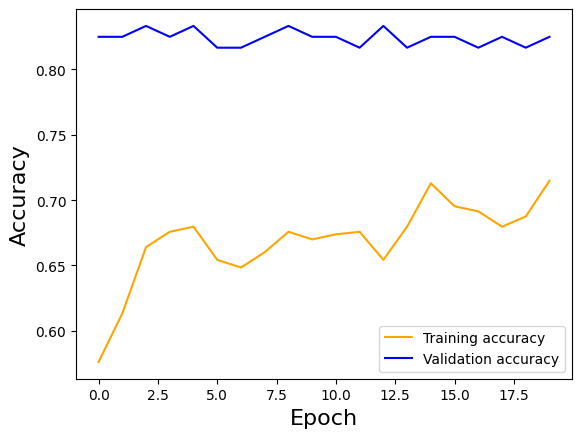

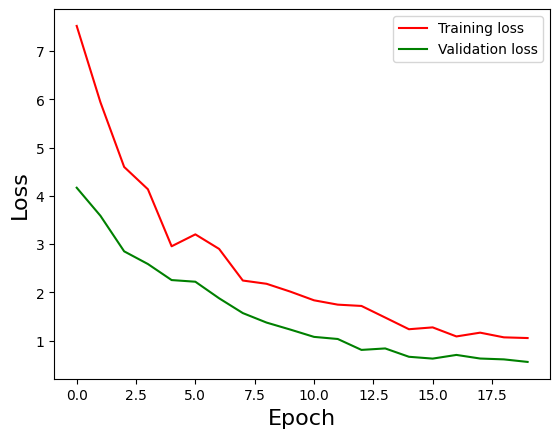

In [32]:
#--------EDIT THIS CELL------------

# Write code to plot learning curves
# for both training and validation (accuracy and loss)
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize = 16)
plt.show()

plt.figure()
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

# Create the Test dataset

In [33]:
model.load_weights('best_model_lesson2.h5')
test_dataset.prepare()
print(len(test_dataset.image_ids))

2504


1/1 [==============================] - 0s 61ms/step


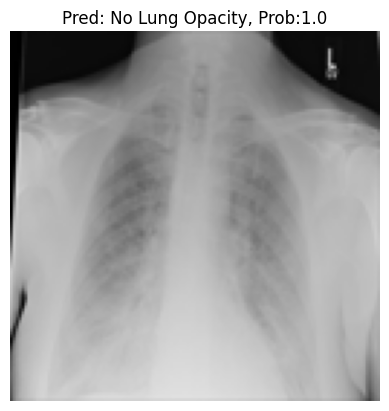

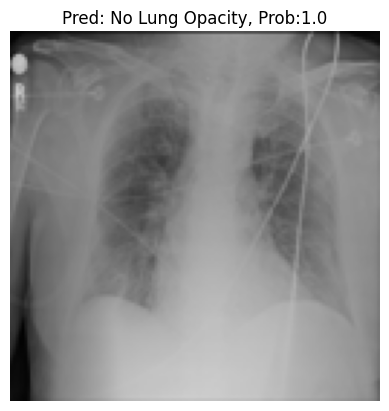

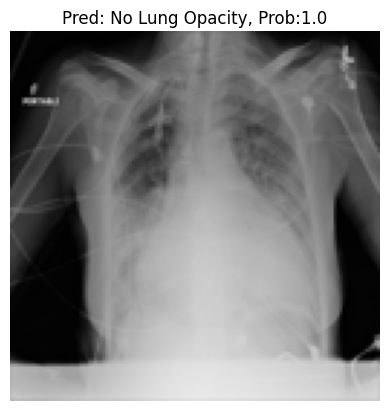

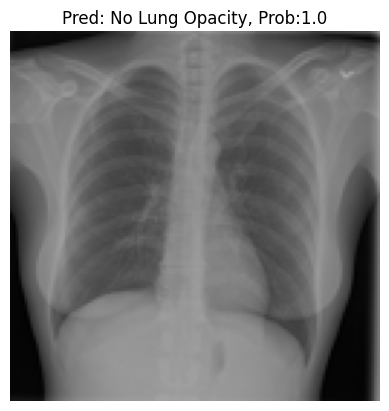

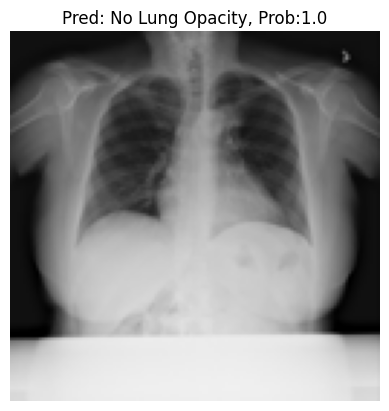

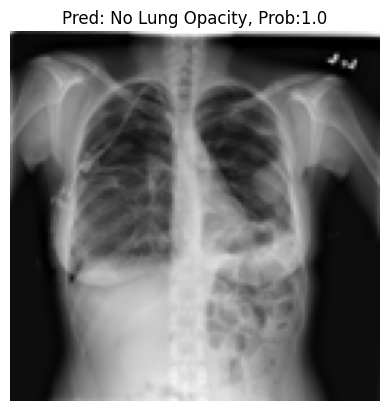

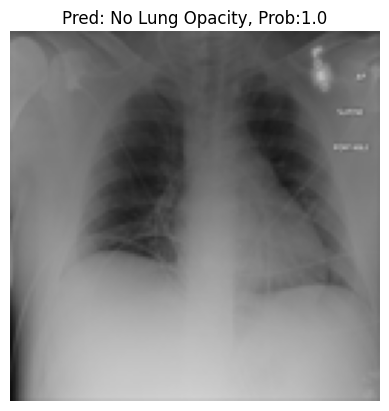

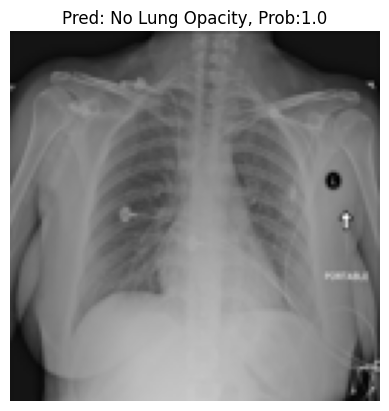

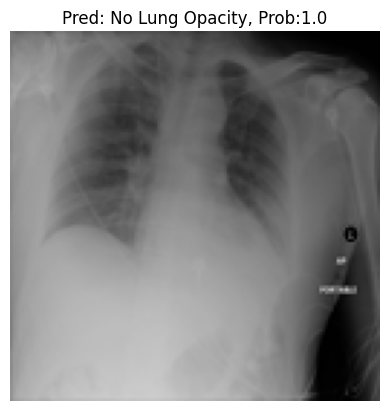

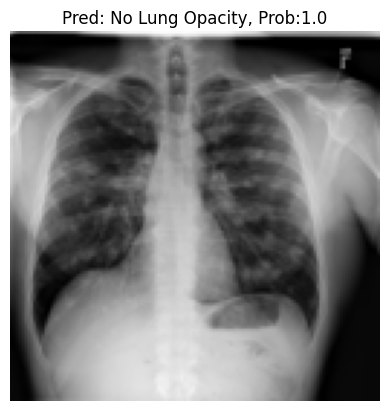

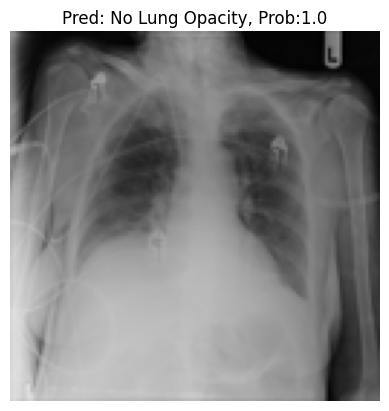

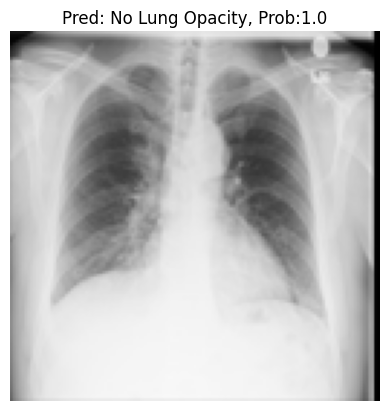

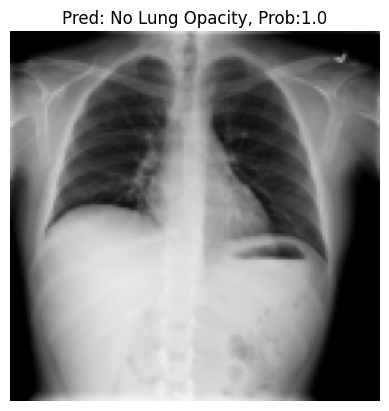

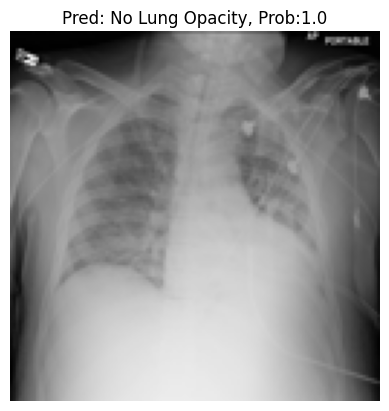

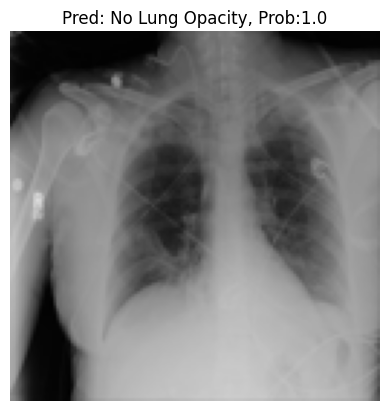

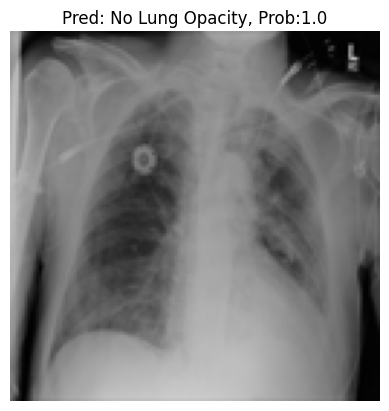

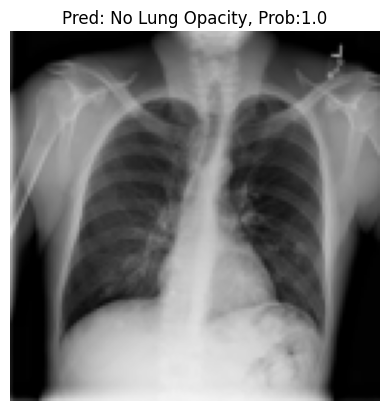

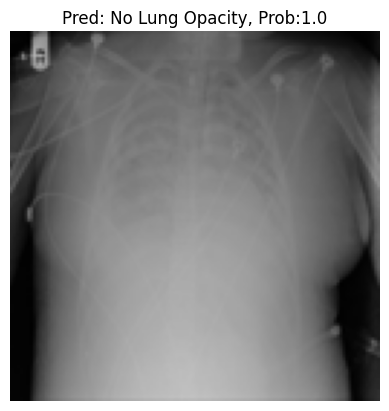

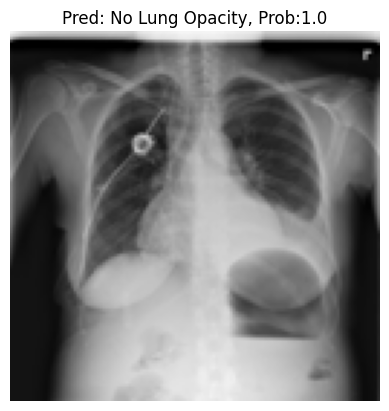

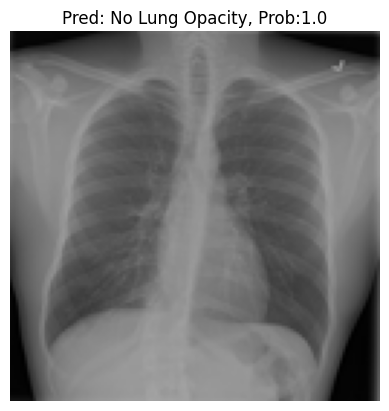

In [34]:
import numpy as np
#from skimage.transform import resize
from PIL import Image

for image_id in test_dataset.image_ids[80:100]:

    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))

    x = np.expand_dims(image, axis=0)
    y_prob = model.predict(x)
    y_classes = y_prob.argmax(axis=-1)

    title = 'Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', Prob:' + str(round(y_prob[0][y_classes[0]], 3))

    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')

plt.show()

### Success!!!

Feel free to continue working further on in this notebook to:

- Develop new models
- Work on ways to evaluate models
- etc. etc. etc.